# 3D CUBES

## Imports

In [89]:
from nbodykit.lab import *
from nbodykit import style, setup_logging

import corner
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random

import sys, pickle, time, os, h5py

from nbodykit.source.catalog import BinaryCatalog
# nbodykit cosmology parameters initialization
from nbodykit.lab import FFTPower

## Dictionaries

In [90]:
COSMOPAR = {
#                   | Om   | Ob   |   h   |  n_s  | s_8 | Mnu | w |

    'fiducial' :    [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0, -1],
    'zeldovich':    [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0, -1],
    
    'Mnu_p' :       [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0.1, -1],
    'Mnu_pp' :      [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0.2, -1],
    'Mnu_ppp' :     [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0.4, -1],
    
    'h_m' :         [0.3175, 0.049, 0.6511, 0.9624, 0.834, 0, -1],
    'h_p' :         [0.3175, 0.049, 0.6911, 0.9624, 0.834, 0, -1],
    
    'ns_m' :        [0.3175, 0.049, 0.6711, 0.9424, 0.834, 0, -1],
    'ns_p' :        [0.3175, 0.049, 0.6711, 0.9824, 0.834, 0, -1],
    
    'Ob_m' :        [0.3175, 0.048, 0.6711, 0.9624, 0.834, 0, -1],
    'Ob_p' :        [0.3175, 0.050, 0.6711, 0.9624, 0.834, 0, -1],
    'Ob2_m' :       [0.3175, 0.047, 0.6711, 0.9624, 0.834, 0, -1],
    'Ob2_p' :       [0.3175, 0.051, 0.6711, 0.9624, 0.834, 0, -1],
    
    'Om_m' :        [0.3075, 0.049, 0.6711, 0.9624, 0.834, 0, -1],
    'Om_p' :        [0.3275, 0.049, 0.6711, 0.9624, 0.834, 0, -1],
    
    's8_m' :        [0.3175, 0.049, 0.6711, 0.9624, 0.819, 0, -1],
    's8_p' :        [0.3175, 0.049, 0.6711, 0.9624, 0.849, 0, -1]
}

folders_ordered = {
    0 :'fiducial'  ,    
    1 :'h_m'       , 
    2 :'h_p'       ,    
    3 :'Mnu_p'     , 
    4 :'Mnu_pp'    ,
    5 :'Mnu_ppp'   ,
    6 :'ns_m'      , 
    7 :'ns_p'      ,    
    8 :'Ob2_m'     , 
    9 :'Ob2_p'     ,    
    10 :'Om_m'      , 
    11 :'Om_p'      ,
    12 :'s8_m'      , 
    13 :'s8_p'      ,
    14 :'zeldovich' ,}

order_folders = {
    'fiducial'  : 0,
    'h_m'       : 1,  'h_p'       : 2,
    'Mnu_p'     : 3,  'Mnu_pp'    : 4, 'Mnu_ppp'   : 5, 
    'ns_m'      : 6,  'ns_p'      : 7,
    'Ob2_m'     : 8,  'Ob2_p'     : 9,
    'Om_m'      : 10, 'Om_p'      : 11,
    's8_m'      : 12, 's8_p'      : 13,
    'zeldovich' : 14
}

# order_dimension = {
#     'Om'  : 0, 'Om ' : 0,
#     'Ob'  : 1, 'Ob ' : 1, 'Ob2' : 1,
#     'h'   : 2, 'h  ' : 2, # 4
#     'ns'  : 3, 'ns ' : 3,
#     's8'  : 4, 's8 ' : 4, # 2
#     'Mnu' : 5
# }

order_dimension = {
    'Om'  : 0, 'Om ' : 0,
    'Ob'  : 1, 'Ob ' : 1, 'Ob2' : 1,
    's8'  : 2, 's8 ' : 2,
    'ns'  : 3, 'ns ' : 3,
    'h'   : 4, 'h  ' : 4,
    'Mnu' : 5
}

"""Om, Ob, s8, ns, h, Mnu"""

cosmological_pars = {
    'Om'  : 0, 'Ob'  : 1, 'h'   : 2,
    'ns'  : 3, 's8'  : 4, 'Mnu' : 5
}

VarCosmoPar = {
    'd_h'  : 0.02, 'd_ns' : 0.02,  'd_Ob' : 0.001, 'd_Ob2': 0.002,
    'd_Om' : 0.01, 'd_s8' : 0.015
}

fiducial_vals = {
    'Ob'  : 0.3175, 'Ob2' : 0.3175,
    'Om'  : 0.049,
    'h'   : 0.6711,
    'n_s' : 0.9624, 'ns'  : 0.9624,
    's_8' : 0.834,  's8'  : 0.834,
    'Mnu' : 0
}

## Functions

In [91]:
def correlation_matrix(m):
    """Calculates the correlation matrix of matrix m_ij."""
    avg = np.average(m, axis=0)
    dim = len(avg)
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # VARIATION
    sigma = []
    for i in range(dim):
        sigma.append(np.sum((avg[i] - m[i])**2))
    sigma = np.sqrt(sigma)
    
    sigma_bis = []
    for i in range(dim):
        cum = 0
        for j in range(len(m[i])):
            cum += (avg[i] - m[i][j])**2
        sigma_bis.append(cum)
    sigma_bis = np.sqrt(sigma_bis)        
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # CORRELATION MATRIX
    CORR = np.zeros((dim, dim))
    for i in range(dim):
        for j in range(dim):
            cum = 0
            for k in range(len(m[i])):
                cum += (avg[i] - m[i][k])*(avg[j] - m[j][k])
            CORR[i, j] = cum  / (sigma_bis[i] * sigma_bis[j])

    if np.linalg.det(CORR) == 0:
        print("¶ WARNING: correlation matrix is singular")
    
    return CORR

def Hartlap(mat, Nr = 350):
    """Calculates inverse matrix using Hartlap correction.
    Arguments:
    - `mat`: input matrix to invert
    - `Nr`: nuber of realization used o calculated the matrix
    """
    return (Nr-len(mat)-2)/(Nr-1)*np.linalg.inv(mat)

def info_name(name):
    """Obtain realization information from namefile"""
    print("TYPE: ", type(name))
    info = name.split('_')[-3:]
    print("TYPE: ", info, "\n", type(info))
    info[2] = info[2].replace(".wst", "")
    N_hgrid = info[0]
    N_WSTgrid = info[1]
    n_realiz = info[2].replace(".wst", "")
    
    return [int(N_hgrid), int(N_WSTgrid), int(n_realiz)]

def cosmo_parser(name):
    """Obtain cosmology from .wst file"""
    info = name.split('_')
    if info[0] == "fiducial":
        return info[0]
    elif info[0] == "zeldovich":
        return info[0]
    else:
        return info[0] + "_" + info[1]
    
def covariation_matrix(m):
    """Calculates the correlation matrix of matrix m_ij.
    """
    print('Shape: ' + str(np.shape(m)))
    avg = np.average(m, axis=0)    # mean values
    dim = len(avg)                 # number of variables
    N = len(m[0])                  # number of values per varaible
    print('len matr ' + str(len(m[0])))
    print('   len avg ' + str(dim))
    COV = np.zeros((dim, dim))
    for i in range(dim):
        for j in range(dim):
            cum = 0.
            for k in range(N):
                cum += (
                    avg[i] -
                    m[i][k])*\
                    (avg[j] - 
                     m[j][k])
            COV[i, j] = cum/N

    if np.linalg.det(COV) == 0:
        print("¶ WARNING: correlation matrix is singular")
    
    return COV

def error_message(a = "ERROR >.<"):
    N = len(a)
    print("")
    print(" "*6 + "_"*N)
    print(" "*5+"/" + " "*N + "\\")
    print(" === | " + a + "| ===")
    print(" "*5 + "\\" + "_"*N + "/" )
    print("")

def mean_coeffs(M):
    X, Y = np.shape(M)
    r = np.zeros(Y)
    M *= 1e-14
    for j in range(Y):  # indice coeff
        c = 0
        for i in range(X): # indice realiz
            c += (M[i][j]/X)
        r[j] = c
    return r*1e14

## Main

### General definitions

In [92]:
root_WST = "/home/fuffolo97/TESI/WST_3D_files/"
root_Pk  = "/home/fuffolo97/TESI/Pk_3D_files/"
files_to_read_wst = os.listdir(root_WST)
files_to_read_pk = os.listdir(root_Pk)
files_to_read_pk.remove('ArrayK.hdf5')


In [93]:
folders = [
    'fiducial', 'zeldovich', 'h_m', 'h_p', 'Mnu_p', 'Mnu_pp' ,'Mnu_ppp',
    'ns_m', 'ns_p', 'Ob2_m', 'Ob2_p',
    'Om_m', 'Om_p', 's8_m', 's8_p'
]
cosmologies = [
    'fiducial', 'zeldovich', 'h_m', 'h_p', 'Mnu_p', 'Mnu_pp' ,'Mnu_ppp',
    'ns_m', 'ns_p', 'Ob2_m', 'Ob2_p',
    'Om_m', 'Om_p', 's8_m', 's8_p'
]
parameter_name = ['Om ', 'Ob ', 'h  ', 'ns ', 's8 ', 'Mnu']

In [94]:
# fiducial_wst_real = []
# zeldovich_wst_real = []
# fiducial_pk_real = []
# zeldovich_pk_real = []
# coeffs_wst = np.zeros((len(cosmologies),  75))
# coeffs_pk  = np.zeros((len(cosmologies), 159))

### Read files: WST and Pk

In [95]:
every_mean_wst = np.zeros((len(order_folders), 75))

for FC in tqdm(range(len(files_to_read_wst))):
    every_wst = []
    fname = files_to_read_wst[FC]
    cosmo = cosmo_parser(files_to_read_wst[FC])
    assert cosmo in files_to_read_wst[FC]
    index = order_folders[cosmo]

    if fname == 'fiducial': num = 1000
    elif 'ZA' in fname: num = 500
    else: num = 350

    with h5py.File(root_WST+fname, 'r') as f:
        for i in range(num):
            dat = np.array(f[f'{cosmo}_{i}_wst'])
            every_wst.append(dat)
    every_mean_wst[index] = np.mean(every_wst, axis=0)

100%|██████████| 15/15 [00:01<00:00, 10.71it/s]


In [96]:
every_mean_pk = np.zeros((len(order_folders), 159))
# real_power    = np.zeros((len(order_folders), 159))
every_mean_Nnoise = np.zeros((len(order_folders), 159))
all_noises = []

for FC in tqdm(range(len(files_to_read_pk))):
    every_pk = []
    every_pk_Nnoise = []
    every_power = []
    fname = files_to_read_pk[FC]
    cosmo = cosmo_parser(files_to_read_pk[FC])
    assert cosmo in files_to_read_pk[FC]
    index = order_folders[cosmo]

    if fname == 'fiducial': num = 1000
    elif 'ZA' in fname: num = 500
    else: num = 350

    with h5py.File(root_Pk+fname, 'r') as f:
        for i in range(num):
            pk_real = np.array(f[f'{cosmo}_{i}_pk'])
            noise = np.array(f[f'{cosmo}_{i}_noise'])
            every_pk.append(pk_real)
            every_pk_Nnoise.append(pk_real-noise)
    every_mean_pk[index] = np.mean(every_pk, axis=0)
    every_mean_Nnoise[index] = np.mean(every_pk_Nnoise, axis=0)

100%|██████████| 15/15 [00:02<00:00,  5.58it/s]


### Calc derivates

In [97]:
deriavates_wst = np.zeros((len(cosmological_pars),  75))
deriavates_pk  = np.zeros((len(cosmological_pars), 159))

for i in cosmological_pars:
    if "Mnu" not in i and "Ob" not in i:
        ind = order_dimension[i]
        deriavates_wst[ind]=(every_mean_wst[order_folders[i+"_p"]]-every_mean_wst[order_folders[i+"_m"]])\
                    /  (2 * VarCosmoPar['d_'+i] * fiducial_vals[i] )
        deriavates_pk[ind]=(every_mean_pk[order_folders[i+"_p"]]-every_mean_pk[order_folders[i+"_m"]])\
                    /  (2 * VarCosmoPar['d_'+i] * fiducial_vals[i] )

    elif "Mnu" in i:
        # deriavates_wst[order_dimension['Mnu']] = (every_mean_wst[order_folders["Mnu_p"]] - every_mean_wst[order_folders["zeldovich"]]) / (0.1)
        # deriavates_pk[order_dimension['Mnu']]  = (every_mean_pk[order_folders["Mnu_p"]]  - every_mean_pk[order_folders["zeldovich"]])  / (0.1)

        deriavates_wst[order_dimension['Mnu']] = \
            (every_mean_wst[order_folders['Mnu_ppp']] - 12 * every_mean_wst[order_folders['Mnu_pp']] + 32 * every_mean_wst[order_folders["Mnu_p"]] - 12 * every_mean_wst[order_folders['fiducial']]) / (12 * 0.1) #- \
            # (every_mean_wst[order_folders["Mnu_pp"]] - 4 * every_mean_wst[order_folders['Mnu_p']] - 3 * every_mean_wst[order_folders['fiducial']]) / 0.1+ \
            # (every_mean_wst[order_folders["Mnu_ppp"]] - every_mean_wst[order_folders['fiducial']]) / 0.1
        deriavates_pk[order_dimension['Mnu']] = \
            (every_mean_pk[order_folders['Mnu_ppp']] - 12 * every_mean_pk[order_folders['Mnu_pp']] + 32 * every_mean_pk[order_folders["Mnu_p"]] - 12 * every_mean_pk[order_folders['fiducial']]) / (12 * 0.1) #- \
            # (every_mean_pk[order_folders["Mnu_pp"]] - 4 * every_mean_pk[order_folders['Mnu_p']] - 3 * every_mean_pk[order_folders['fiducial']]) / 0.1+ \
            # (every_mean_pk[order_folders["Mnu_ppp"]] - every_mean_pk[order_folders['fiducial']]) / 0.1


    elif "Ob" in i:
        deriavates_wst[order_dimension['Ob']] = \
            (every_mean_wst[order_folders[i+"2_p"]]-\
             every_mean_wst[order_folders[i+"2_m"]]) \
                / (2 * VarCosmoPar['d_'+i+"2"] * fiducial_vals[i] )
        deriavates_pk[order_dimension['Ob']] = \
            (every_mean_pk[order_folders[i+"2_p"]]-\
             every_mean_pk[order_folders[i+"2_m"]]) \
                / (2 * VarCosmoPar['d_'+i+"2"] * fiducial_vals[i] )


### Calc Fisher Matrix

In [98]:
# cov_wst = covariation_matrix(fiducial_wst)
# cov_pk  = covariation_matrix(fiducial_pk)
fiducial_wst = []
with h5py.File(root_WST+'fiducial_wst_real.hdf5', 'r') as f:
    for i in range(1000):
        dat = np.array(f[f'fiducial_{i}_wst'])
        fiducial_wst.append(dat)

fiducial_wst = np.array(fiducial_wst).transpose()

cov_wst = np.cov(fiducial_wst)

# inverting with Hartlap factor
Hart_wst = Hartlap(cov_wst, 1000)

# initialize empty Fisher matrix
Fish_wst, Fish_pk  = np.zeros((6,6)), np.zeros((6,6))

# create Fisher matrix
for a in range(6):
    for b in range(6):
        Fish_wst[a, b]  = np.sum(deriavates_wst[a]  * (Hart_wst  * deriavates_wst[b]))

# GETTING CONATRAINS:
# create inverse of Fisher matrix
inverse_wst = np.linalg.inv(Fish_wst)

# initialize empty array containing diagonal elements
diagonal_wst = []

# inizialize empty matrix containing all correletions
constrains_wst = np.zeros((6,6))
constrains_wst_mod = np.zeros((6,6))

# `for loop`: assegnate diaconal elements
for i in range(len(inverse_wst)):
    diagonal_wst.append(inverse_wst[i, i])
    # internal `for loop`: assegnate all the correlations
    for j in range(6):
        constrains_wst[i, j] = inverse_wst[i, j]

# # after checking symmetric elements are almost equal, set them as equal
# # this is needed because exact symm. matrix is needed
# for i in range(6):
#     for j in range(6):
#         # assert (np.abs(constrains_wst[i, j] - constrains_wst[j, i])/np.mean((constrains_wst[i, j], constrains_wst[j, i])) < 1e-5),\
#         #         f'({i}; {j}): {constrains_wst[i, j]}, {constrains_wst[j, i]}'
#         if j>i: constrains_wst_mod[i, j] = constrains_wst_mod[j, i] = np.abs(constrains_wst[i, j])

In [99]:
fiducial_pk, fiducial_pk_Nnoise = [], []
with h5py.File(root_Pk+'fiducial_pk_real.hdf5', 'r') as f:
    for i in range(1000):
        pk_real = np.array(f[f'fiducial_{i}_pk'])
        noise = np.array(f[f'fiducial_{i}_noise'])
        fiducial_pk.append(pk_real)
        fiducial_pk_Nnoise.append(pk_real-noise)

# cov_wst = covariation_matrix(fiducial_wst)
# cov_pk  = covariation_matrix(fiducial_pk)

fiducial_pk = np.array(fiducial_pk).transpose()
print(np.shape(fiducial_pk))
cov_pk  = np.cov(fiducial_pk)

# inverting with Hartlap factor
Hart_pk = Hartlap(cov_pk, 1000)

# initialize empty Fisher matrix
Fish_pk  = np.zeros((6,6))

# create Fisher matrix
for a in range(6):
    for b in range(6):
        Fish_pk[a, b]   = np.sum(deriavates_pk[a]   * (Hart_pk   * deriavates_pk[b]))

# GETTING CONATRAINS:
# create inverse of Fisher matrix
inverse_pk = np.linalg.inv(Fish_pk)

# initialize empty array containing diagonal elements
diagonal_pk = []

# inizialize empty matrix containing all correletions
constrains_pk = np.zeros((6,6))
constrains_pk_mod = np.zeros((6,6))

# `for loop`: assegnate diaconal elements
for i in range(len(inverse_pk)):
    diagonal_pk.append(inverse_pk[i, i])
    # internal `for loop`: assegnate all the correlations
    for j in range(6):
        constrains_pk[i, j] = inverse_pk[i, j]

# after checking symmetric elements are almost equal, set them as equal
# this is needed because exact symm. matrix is needed
# for i in range(6):
#     for j in range(6):
#         # assert (np.abs(constrains_pk[i, j] - constrains_pk[j, i])/np.mean((constrains_pk[i, j] - constrains_pk[j, i])) < 1e-5), f'{np.abs(constrains_pk[i, j] - constrains_pk[j, i])/np.mean((constrains_pk[i, j] - constrains_pk[j, i]))}'
#         if j>i: constrains_pk_mod[i, j] = constrains_pk_mod[j, i] = np.abs(constrains_pk[i, j])


# # create correlation graphs, maybe useful to confront with wst
# sns.heatmap(corr.transpose())
# plt.gca().invert_yaxis()
# plt.savefig('correlation_matrix_pk.pdf', format='pdf')

# sns.heatmap(corr_rsd.transpose())
# plt.gca().invert_yaxis()
# plt.savefig('correlation_matrix_rsd_pk.pdf', format='pdf')

# # save constrains in a file
# with open("./ZZ_results/constrains_pk.res", "ab") as f:
#     pickle.dump(constrains, f)
# with open("./ZZ_results/constrains_rsd_pk.res", "ab") as f:
#     pickle.dump(constrains_rsd, f)

(159, 1000)


# GRAPHs

In [100]:
k_array = []
with h5py.File(root_Pk+'ArrayK.hdf5', 'r') as f:
    dat = np.array(f['k_array'])
    k_array.append(dat)
k_array = np.array(k_array[0])

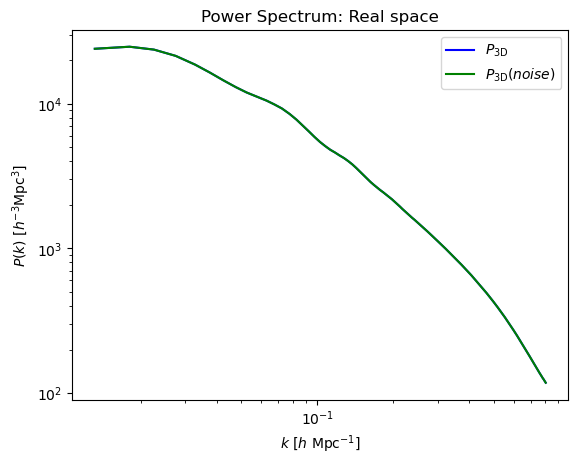

<Figure size 1500x1000 with 0 Axes>

In [101]:
plt.loglog(k_array, every_mean_Nnoise[order_folders['fiducial']], label=r"$P_\mathrm{3D}$", color="b")
plt.loglog(k_array, every_mean_pk[order_folders['fiducial']], label=r"$P_\mathrm{3D}(noise)$", color="g")

# format the axes
plt.legend(loc=0)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.title("Power Spectrum: Real space")
#plt.xlim(0.06, 0.9)
plt.figure(figsize=(15, 10));

/home/fuffolo97/anaconda3/envs/thesis/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


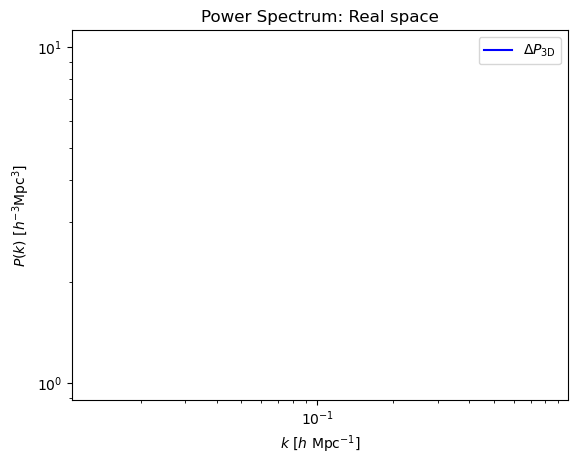

<Figure size 1500x1000 with 0 Axes>

In [102]:
plt.loglog(
    k_array,
    every_mean_pk[order_folders['fiducial']] - every_mean_Nnoise[order_folders['fiducial']],
    label=r"$\Delta P_\mathrm{3D}$",
    color="b"
)

# format the axes
plt.legend(loc=0)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.title("Power Spectrum: Real space")
#plt.xlim(0.06, 0.9)
plt.figure(figsize=(15, 10));

In [119]:
Bins = 300
# mean_vals = np.array((0.3175, 0.049, 0.6711, 0.9624, 0.834, 0))
mean_vals = np.array((0.3175, 0.049, 0.834, 0.9624, 0.6711, 0))

In [104]:
# for i in range(len(constrains_wst)):
#     for j in range(len(constrains_wst)):
#         constrains_wst[i][j] = round(constrains_wst[i][j], 8)
#         constrains_pk[i][j] = round(constrains_pk[i][j], 8)

In [105]:
# for i in range(len(constrains_wst)):
#     for j in range(len(constrains_wst)):
#         if j>i: print(f'{constrains_wst[i][j] - constrains_wst[j][i]}         {constrains_pk[i][j] - constrains_pk[j][i]}')

In [106]:
data_wst = np.random.multivariate_normal(
    mean = mean_vals,
    cov = constrains_wst,
    size = 1000000
)
data_pk = np.random.multivariate_normal(
    mean = mean_vals,
    cov = constrains_pk,
    size = 1000000
)
# data_wst_mod = np.random.multivariate_normal(
#     mean = mean_vals,
#     cov = constrains_wst_mod,
#     size = 300000
# )
# data_pk_mod = np.random.multivariate_normal(
#     mean = mean_vals,
#     cov = constrains_pk_mod,
#     size = 300000
# )

/tmp/ipykernel_13069/1341448312.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  data_wst = np.random.multivariate_normal(
/tmp/ipykernel_13069/1341448312.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  data_pk = np.random.multivariate_normal(


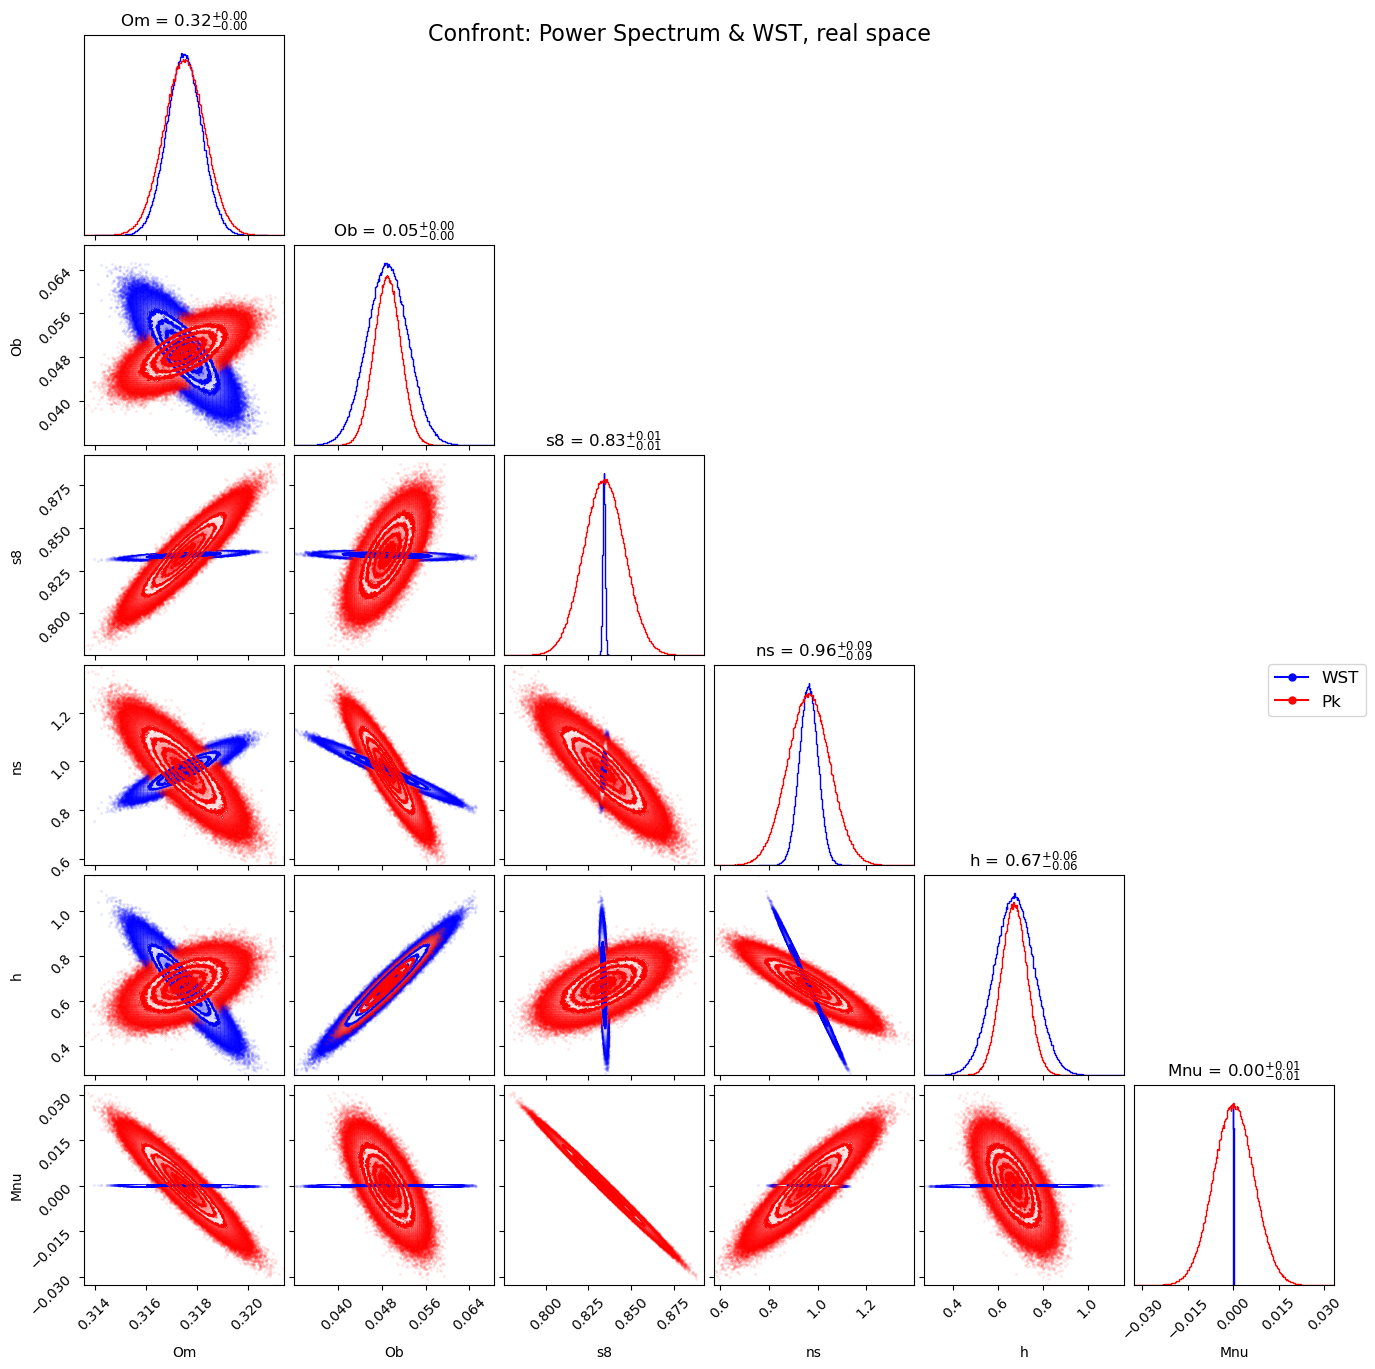

In [120]:
figure1 = corner.corner(
    data_wst,
    labels=['Om', 'Ob', 's8', 'ns','h', 'Mnu'],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    bins = Bins,
    # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
    color='b',
    hist_kwargs={"color": "b"},
    contour_kwargs={"colors": "b"}
)
corner.corner(
    data_pk,
    labels=['Om', 'Ob', 's8', 'ns','h', 'Mnu'],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    bins = Bins,
    # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
    color='r',
    hist_kwargs={"color": "r"},
    contour_kwargs={"colors": "r"},
    fig=figure1
)

figure1.suptitle('Confront: Power Spectrum & WST, real space', fontsize=16)

wst_patch = Line2D([0], [0], marker='.', color='b', markerfacecolor='blue', markersize=10, label='WST')
pk_patch = Line2D([0], [0], marker='.', color='r', markerfacecolor='red', markersize=10, label='Pk')
figure1.legend(
    handles=[wst_patch, pk_patch],
    loc='center right',
    fancybox=True,
    bbox_to_anchor=(1, 0.5),
    fontsize='large'
)
#plt.legend(handles=[wst_patch, pk_patch], loc='upper right')
plt.savefig("WST_PK_real_cubes.pdf")
plt.show();

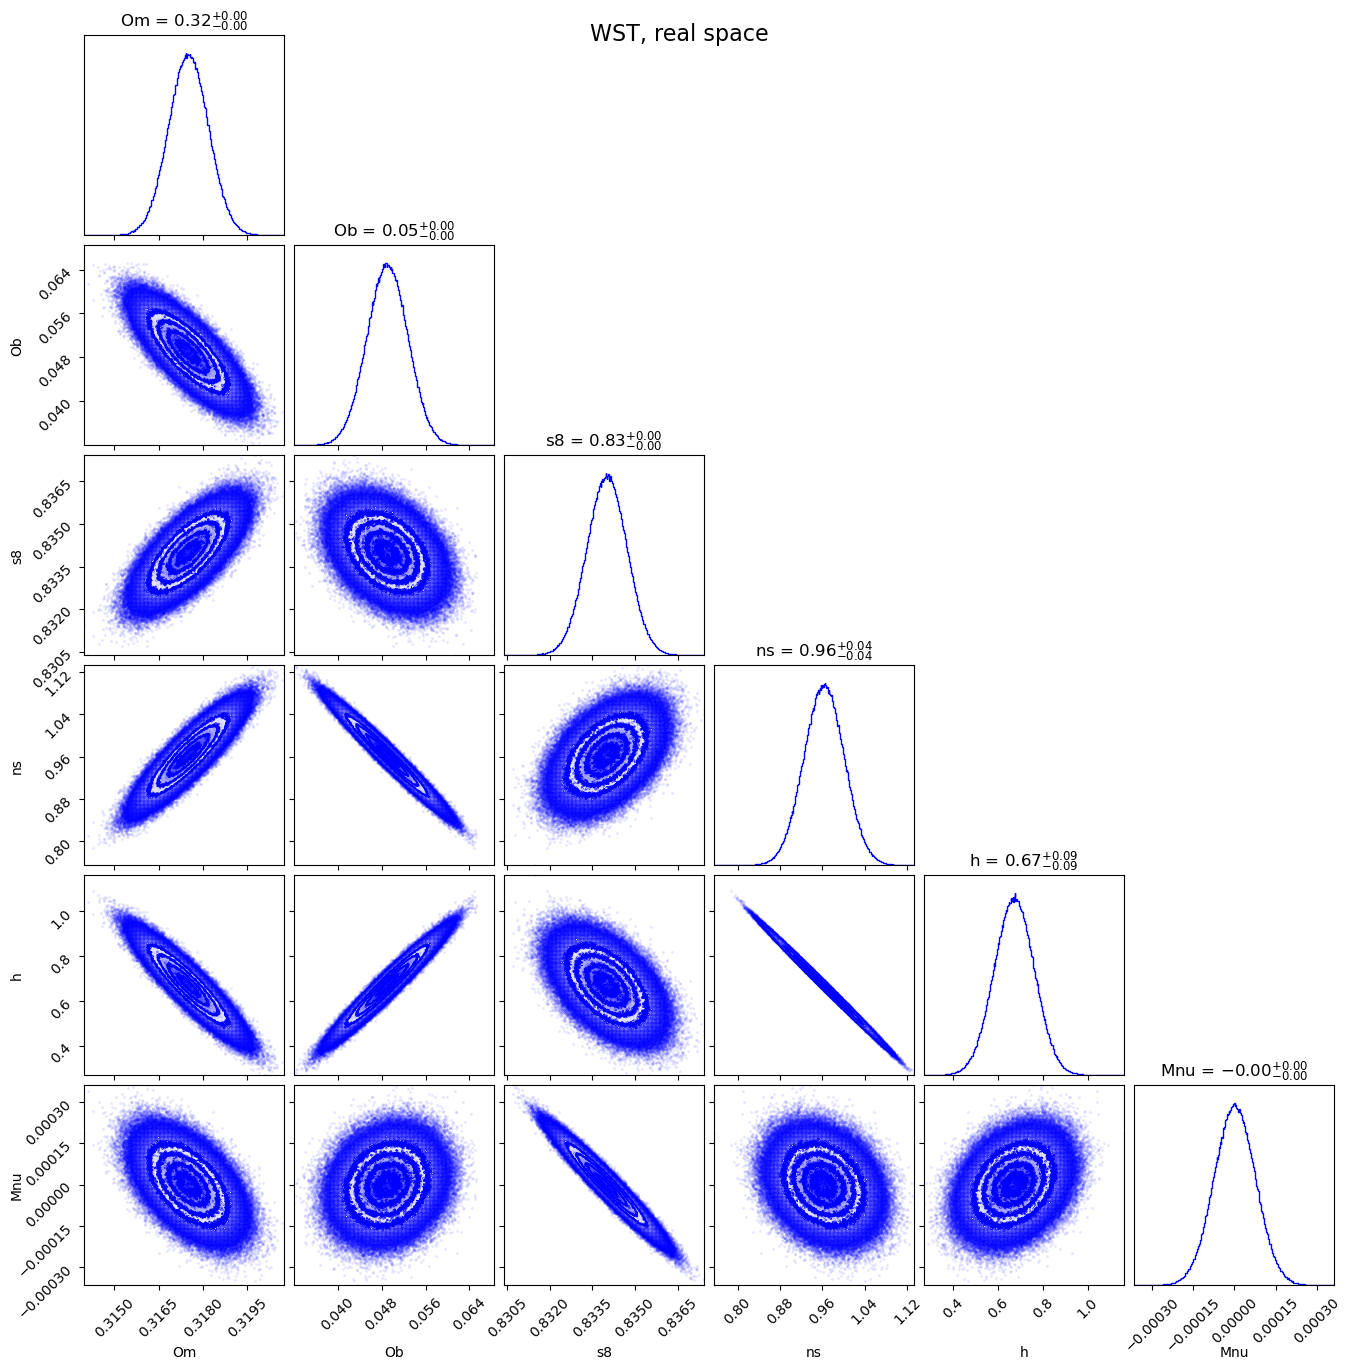

In [108]:
fig_wst = corner.corner(
    data_wst,
    labels=['Om', 'Ob', 's8', 'ns','h', 'Mnu'],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    bins = Bins,
    # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
    color='b',
    hist_kwargs={"color": "b"},
    contour_kwargs={"colors": "b"}
)

fig_wst.suptitle('WST, real space', fontsize=16);

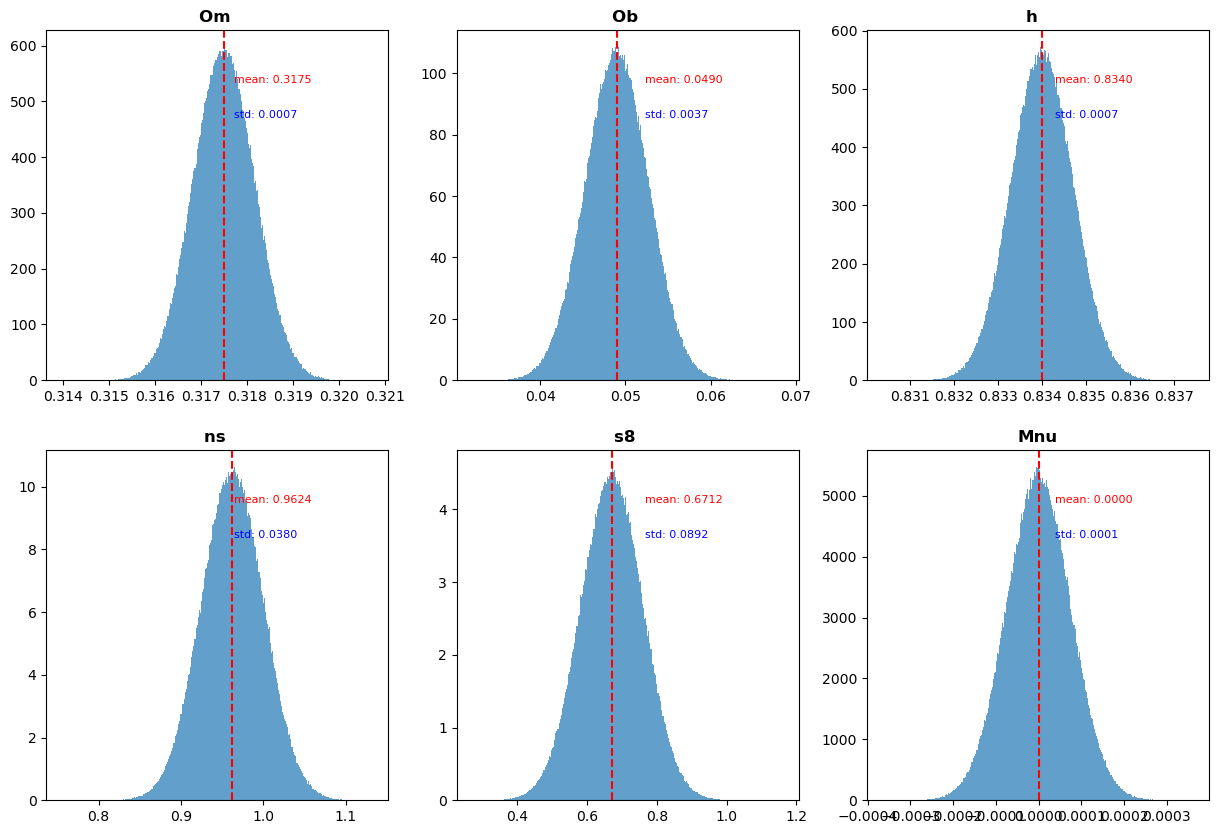

In [116]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=int(data_wst.shape[1]/2),
    figsize=(15, 10),
    gridspec_kw={'height_ratios': [3, 3]}
    )

std_deviations = []
mean_values = []

for i, ax in enumerate(axs.flatten()):
    if i < data_wst.shape[1]:
        # Plotting histograms
        n, bins, _ = ax.hist(data_wst[:, i], bins=500, density=True, alpha=0.7)
        ax.set_title(f'{parameter_name[i]}', fontweight='bold')
        
        # Computing standard deviation and mean for each dimension
        std_dev = np.std(data_wst[:, i])
        std_deviations.append(std_dev)
        
        mean_val = np.mean(data_wst[:, i])
        mean_values.append(mean_val)

        ax.axvline(mean_val, color='r', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_val:.2f}')
        
        # Annotating mean and standard deviation on the histograms
        ax.text(0.55, 0.85, f'mean: {mean_val:.4f}', transform=ax.transAxes, color='red', fontsize=12)
        ax.text(0.55, 0.75, f'std: {std_dev:.4f}', transform=ax.transAxes, color='blue', fontsize=12)
    else:
        ax.axis('off')  # If there are fewer dimensions than subplots, hide the extra subplots

# plt.tight_layout()
plt.savefig("ParDistrs.pdf")
plt.show()

In [114]:
parameter_name_2 = ['Om ', 'Ob ', 's8 ', 'ns ', 'h  ', 'Mnu']
for i in range(len(std_deviations)):
    print(rf'{parameter_name_2[i]}: {round(mean_values[i], 4)} - {round(std_deviations[i], 4)}')

Om : 0.3175 - 0.0007
Ob : 0.049 - 0.0037
s8 : 0.834 - 0.0007
ns : 0.9624 - 0.038
h  : 0.6712 - 0.0892
Mnu: 0.0 - 0.0001


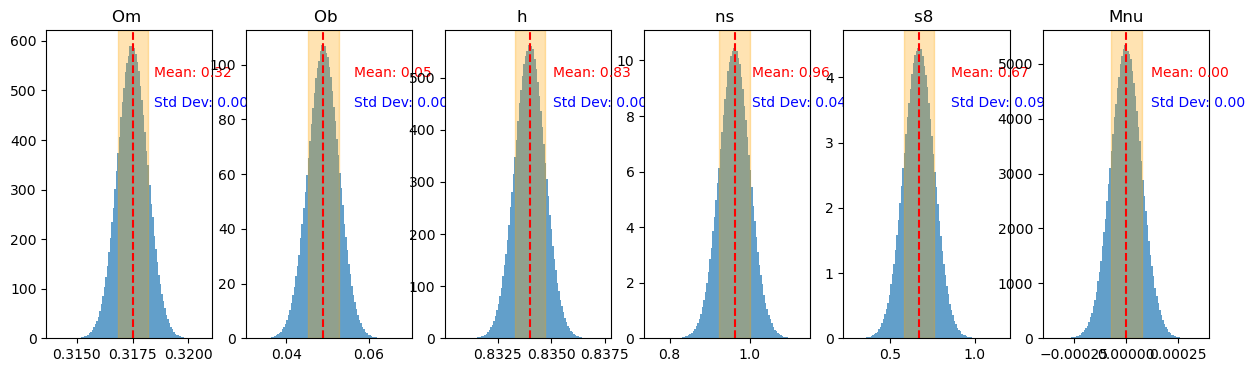

<Figure size 3000x1000 with 0 Axes>

In [113]:
# marginalized_distributions = [np.histogram(data_wst[:, i], bins=20, density=True) for i in range(data_wst.shape[1])]

fig, axs = plt.subplots(nrows=1, ncols=data_wst.shape[1], figsize=(15, 4))
std_deviations = []
mean_values = []

# Marginalizing along each dimension and plotting
for i in range(data_wst.shape[1]):
    ax = axs[i]
    ax.hist(data_wst[:, i], bins=100, density=True, alpha=0.7)
    ax.set_title(f'{parameter_name[i]}')
    
    std_dev = np.std(data_wst[:, i])
    std_deviations.append(std_dev)
    mean_val = np.mean(data_wst[:, i])
    mean_values.append(mean_val)

    ax.axvline(mean_val, color='r', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_val:.2f}')
    ax.axvspan(mean_val - std_dev, mean_val + std_dev, alpha=0.3, color='orange', label=f'std: {std_dev:.2f}')

    ax.text(0.65, 0.85, f'Mean: {mean_val:.2f}', transform=ax.transAxes, color='red', fontsize=10)
    ax.text(0.65, 0.75, f'Std Dev: {std_dev:.2f}', transform=ax.transAxes, color='blue', fontsize=10)

# plt.tight_layout()
plt.figure(figsize=(30, 10));


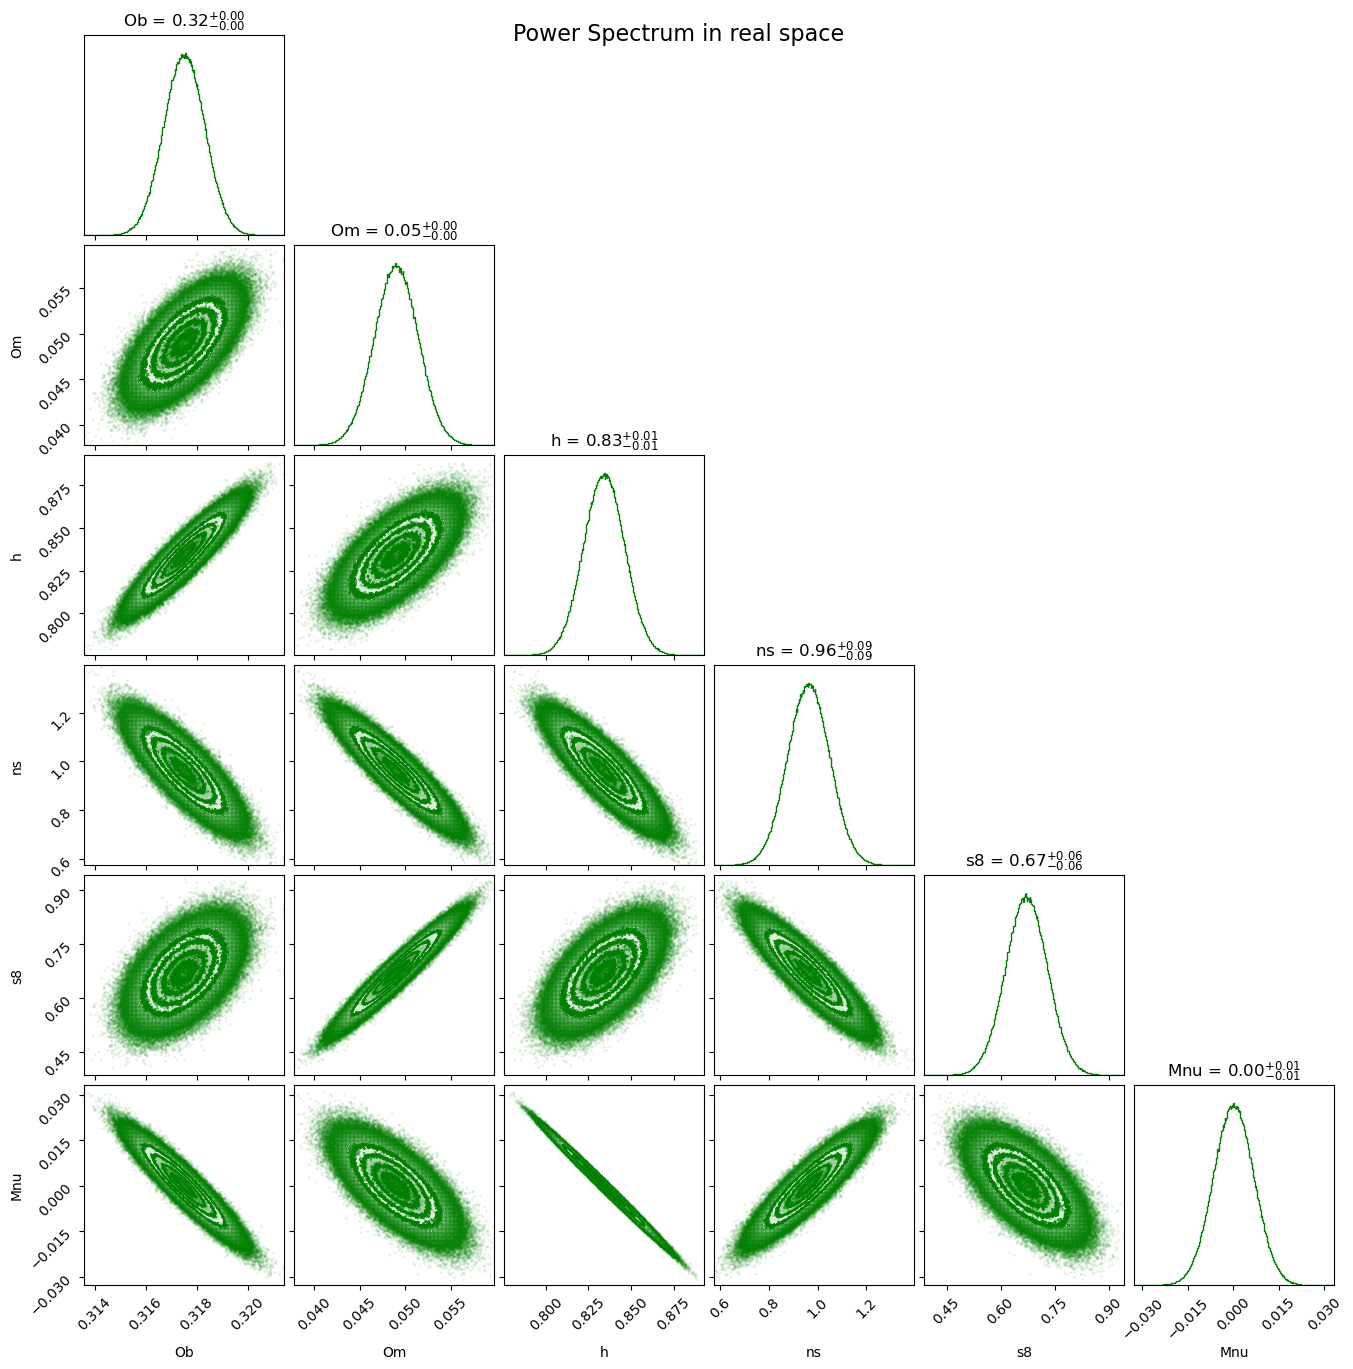

In [115]:
fig_pk = corner.corner(
    data_pk,
    labels=['Ob', 'Om', 'h', 'ns','s8', 'Mnu'],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    bins = Bins,
    # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
    color='g',
    hist_kwargs={"color": "g"},
    contour_kwargs={"colors": "g"}
)

fig_pk.suptitle('Power Spectrum in real space', fontsize=16);
# plt.savefig("PK_coeffs_N_RD.pdf")